# Interaction databases

In [1]:
from flecs.data.utils import load_interaction_data, available_fantom5_tissue_type_files
from flecs.data.interaction_data import InteractionData
from flecs.utils import set_seed, plot_trajectory
from flecs.trajectory import simulate_deterministic_trajectory
from flecs.cell_population import CellPopulation
import torch
import torch_scatter
import matplotlib.pyplot as plt

set_seed(0)

## Quick access to various databases

Use the following function: `flecs.data.utils.load_interaction_data`

In [2]:
print(load_interaction_data.__doc__)


    Utility function which loads interaction data from one of the databases, and returns it as a `InteractionData`
    object.

    Args:
        interaction_type: available options: ["test", "calcium_pathway", "regulon_db", "encode", "fantom5", "string",
            "composite", "fantom5_covid_related_subgraph", "random"].
        realnet_tissue_type_file: only used when `interaction_type` is "fantom5" or "composite".
        tf_only: whether to restrict to transcription factor nodes only.
        subsample_edge_prop:
        n_nodes: only used when `interaction_type` is "random".
        avg_num_parents: only used when `interaction_type` is "random".

    Returns:
        InteractionData
    


In [3]:
regulon_db = load_interaction_data("regulon_db")
print("regulon_db", repr(regulon_db))

regulon_db InteractionData. 1920 nodes and 4558 edges.
2 different types of nodes: ['TF_gene', 'gene'].
2 different types of edges: [('TF_gene', '', 'gene'), ('TF_gene', '', 'TF_gene')].



In [4]:
print(available_fantom5_tissue_type_files())

['04_mesenchymal_mixed.txt.gz', '02_nervous_system_adult_hindbrain.txt.gz', '31_epithelial_cells_of_kidney_uterus.txt.gz', '05_sarcoma.txt.gz', '27_astrocytes_pigment_cells.txt.gz', '15_myeloid_leukemia.txt.gz', '09_connective_tissue_integumental_cells.txt.gz', '25_pineal_gland_eye.txt.gz', '08_connective_tissue_muscle_cells.txt.gz', '20_gastrointestinal_system.txt.gz', '26_neuron-associated_cells_cancer.txt.gz', '18_male_reproductive_organs.txt.gz', '30_extraembryonic_membrane.txt.gz', '29_epithelial_cells.txt.gz', '17_adenocarcinoma.txt.gz', '11_myeloid_leukocytes.txt.gz', '14_immune_organs.txt.gz', '21_heart.txt.gz', '07_mesenchymal_stem_smooth_muscle_cells.txt.gz', '13_lymphoma.txt.gz', '01_neurons_fetal_brain.txt.gz', '_clusters.txt', '24_glands_internal_genitalia.txt.gz', '28_neuroectodermal_tumors_sarcoma.txt.gz', '16_endo-epithelial_cells.txt.gz', '22_mouth_throat_skeletal_muscle_tissue.txt.gz', '23_lung.txt.gz', '06_endothelial_cells.txt.gz', '12_lymphocytes_of_b_lineage.txt.g

In [5]:
fantom5_fetal_brain = load_interaction_data("fantom5", 
                                            realnet_tissue_type_file='01_neurons_fetal_brain.txt.gz')
print("fantom5_fetal_brain", repr(fantom5_fetal_brain))

fantom5_fetal_brain InteractionData. 15104 nodes and 2336118 edges.
2 different types of nodes: ['TF_gene', 'gene'].
2 different types of edges: [('TF_gene', '', 'TF_gene'), ('TF_gene', '', 'gene')].



## Generating random graphs

In [6]:
random_interaction = load_interaction_data("random", n_nodes=12, avg_num_parents=3)
random_interaction

InteractionData. 12 nodes and 29 edges.
1 different types of nodes: [''].
1 different types of edges: [('', '', '')].

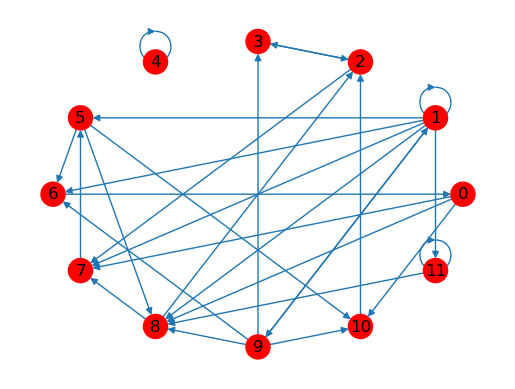

In [7]:
random_interaction.draw()

## Overview of the InteractionData class

In [8]:
print(InteractionData.__init__.__doc__)


        Class which holds interaction data about a Cell, s.a. Gene Regulatory Networks/Pathways.
        It inherits from `nx.DiGraph` and is formatted such that:

        * Nodes and edges are typed, based on a "type" attribute
        * Nodes are ordered based on their type
        * All nodes/edges of a given type have the same set of attributes
        * Node/Edge attributes are either strings or torch.Tensor.

        Once instantiated, the structure of the graph is frozen.

        Args:
            graph (nx.DiGraph): Graph used for initialization.
        


In [9]:
test_data = load_interaction_data("test")

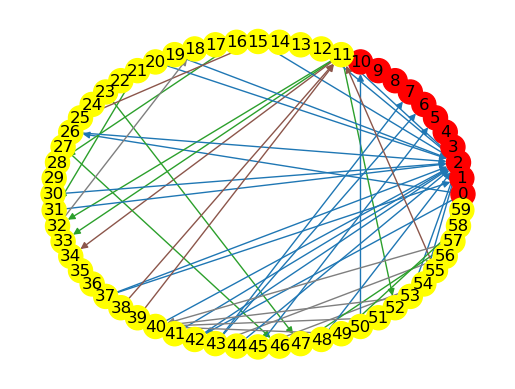

In [10]:
test_data.draw()

In [11]:
print(test_data)

InteractionData. 60 nodes and 57 edges.
2 different types of nodes: ['compound', 'gene'].
6 different types of edges: [('compound', '', 'gene'), ('gene', 'binding/association', 'gene'), ('gene', 'compound', 'gene'), ('gene', 'activation', 'gene'), ('gene', 'inhibition', 'gene'), ('gene', '', 'compound')].
Nodes:
	 node 0 {'type': 'compound', 'name': 'cpd:C11556'}
	 node 1 {'type': 'compound', 'name': 'cpd:C01330'}
	 node 2 {'type': 'compound', 'name': 'cpd:C00076'}
	 node 3 {'type': 'compound', 'name': 'cpd:C13050'}
	 node 4 {'type': 'compound', 'name': 'cpd:C13051'}
	 node 5 {'type': 'compound', 'name': 'cpd:C00575'}
	 node 6 {'type': 'compound', 'name': 'cpd:C00004'}
	 node 7 {'type': 'compound', 'name': 'cpd:C00002'}
	 node 8 {'type': 'compound', 'name': 'cpd:C00165'}
	 node 9 {'type': 'compound', 'name': 'cpd:C01245'}
	 node 10 {'type': 'compound', 'name': 'cpd:C06124'}
	 node 11 {'type': 'gene', 'name': 'hsa:163688', 'basal_expression': tensor([0.2535])}
	 node 12 {'type': 'gene',

## Make your own graph

In [12]:
import networkx as nx


g = nx.DiGraph()
g.add_node(0, type="gene")
g.add_node(1, type="gene")
g.add_node(2, type="protein")
g.add_node(3, type="protein")

g.add_edge(0, 1, type="regulates", weight=-1.)
g.add_edge(1, 0, type="regulates", weight=-1.)
g.add_edge(0, 3, type="codes for")
g.add_edge(1, 2, type="codes for")

small_example_data = InteractionData(g)

In [13]:
print(small_example_data)

InteractionData. 4 nodes and 4 edges.
2 different types of nodes: ['gene', 'protein'].
2 different types of edges: [('gene', 'codes for', 'protein'), ('gene', 'regulates', 'gene')].
Nodes:
	 node 0 {'type': 'gene'}
	 node 1 {'type': 'gene'}
	 node 2 {'type': 'protein'}
	 node 3 {'type': 'protein'}
Edges:
	 edge (0, 1, {'type': 'regulates', 'weight': tensor([-1.])})
	 edge (0, 3, {'type': 'codes for'})
	 edge (1, 0, {'type': 'regulates', 'weight': tensor([-1.])})
	 edge (1, 2, {'type': 'codes for'})



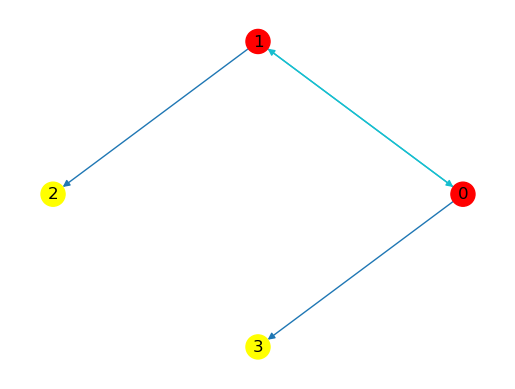

In [14]:
small_example_data.draw()

## Reproduce basic patterns

### Differentiation

In [15]:
from flecs.trajectory import simulate_stochastic_trajectory, simulate_deterministic_trajectory_euler_steps

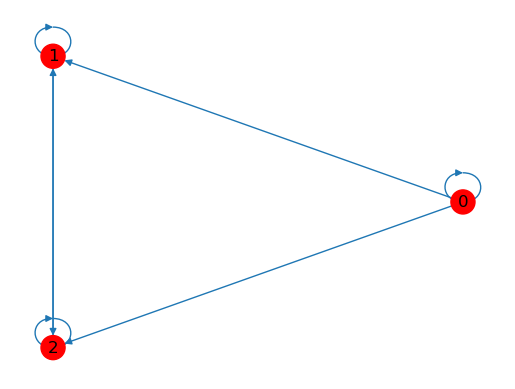

In [16]:
switch_graph = nx.DiGraph()
switch_graph.add_node(0, type = 'gene')
switch_graph.add_node(1, type = 'gene')
switch_graph.add_node(2, type = 'gene')
switch_graph.add_edges_from([(0, 0), (0, 1), (0, 2), (1, 2), (2, 1), (1, 1), (2, 2)])
attrs = {(0, 0): {'type': 'reg', 'is_act': 0., 'beta': 1.},
         (0, 1): {'type': 'reg', 'is_act': 0., 'beta': 1.},
         (0, 2): {'type': 'reg', 'is_act': 0., 'beta': 1.}, 
         (1, 1): {'type': 'reg', 'is_act': 1., 'beta': 1.},
         (2, 2): {'type': 'reg', 'is_act': 1., 'beta': 1.},
         (1, 2): {'type': 'reg', 'is_act': 0., 'beta': 3.}, 
         (2, 1): {'type': 'reg', 'is_act': 0., 'beta': 3.}
        }
nx.set_edge_attributes(switch_graph, attrs)

switch_graph = InteractionData(switch_graph)
switch_graph.draw()

In [17]:
class HillFunctionProductionPop(CellPopulation):
    def __init__(self, g, n_cells):
        super().__init__(g, n_cells=n_cells)
        
    def compute_production_rates(self):
        edges = self['gene', 'reg', 'gene']
        
        # Computes a multi dimensional Hill function with hill coefficients = 1.
        parent_indices = edges.tails
        children_indices = edges.heads
        
        # State of the parents
        X = self['gene'].state[:, parent_indices]
        X_numerator = X ** edges.is_act  # Repressors are set to 1. to compute the numerator
        
        # Message passing
        numerator = torch_scatter.scatter(edges.beta * X_numerator, children_indices, dim=1)
        denominator = 1 + torch_scatter.scatter(edges.beta * X, children_indices, dim=1)

        self['gene'].production_rates = numerator / denominator
        
    def compute_decay_rates(self):
        self['gene'].decay_rates = 0.01 * self['gene'].state

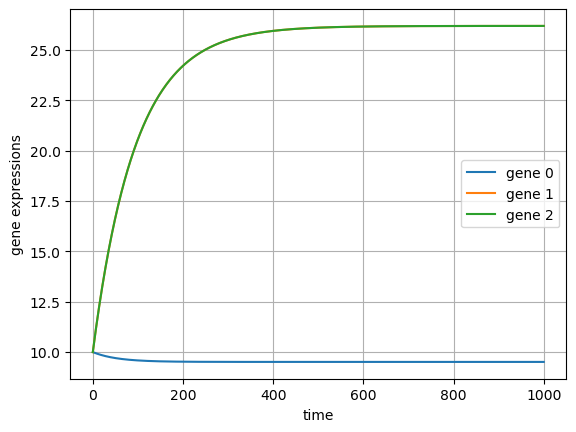

In [18]:
set_seed(0)
switch_cell_pop = HillFunctionProductionPop(switch_graph, n_cells=20)

time_points = torch.linspace(0, 1000, 1000)
cell_traj = simulate_deterministic_trajectory(switch_cell_pop, time_points)
plot_trajectory(cell_traj[:, 0], time_points)

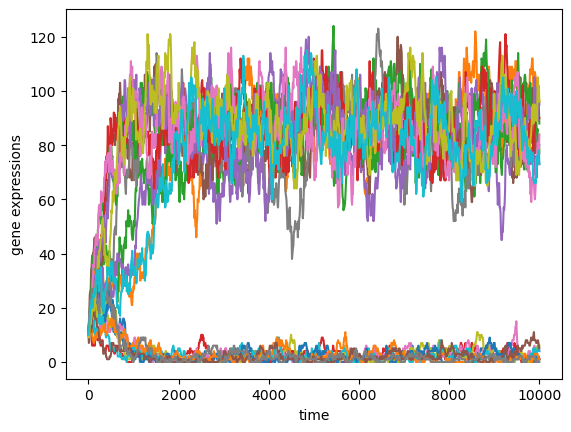

In [19]:
set_seed(0)
switch_cell_pop = HillFunctionProductionPop(switch_graph, n_cells=20)

time_points = torch.linspace(0, 10000, 1000)
cell_traj = simulate_stochastic_trajectory(switch_cell_pop, time_points)

for i in range(20):
    # Print one cell at a time, and only the expression of the second gene
    plot_trajectory(cell_traj[:, i, 1:2], time_points, legend=False)

### Cycles

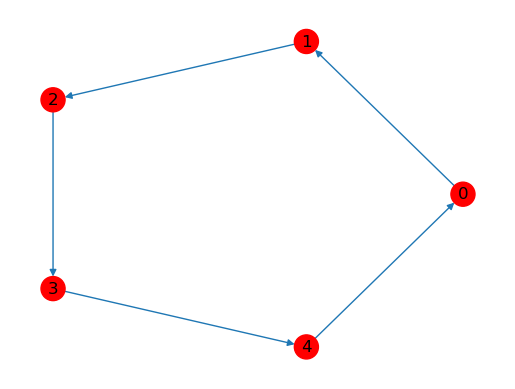

In [20]:
cycle_graph = nx.DiGraph()
cycle_graph.add_node(0, type = 'gene')
cycle_graph.add_node(1, type = 'gene')
cycle_graph.add_node(2, type = 'gene')
cycle_graph.add_node(3, type = 'gene')
cycle_graph.add_node(4, type = 'gene')
cycle_graph.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 4), (4, 0)])
attrs = {(0, 1): {'type': 'reg', 'is_act': 1., 'beta': 1., 'K': 10., 'hill_coeff': 2},
         (1, 2): {'type': 'reg', 'is_act': 1., 'beta': 1., 'K': 10., 'hill_coeff': 2},
         (2, 3): {'type': 'reg', 'is_act': 1., 'beta': 1., 'K': 10., 'hill_coeff': 2}, 
         (3, 4): {'type': 'reg', 'is_act': 1., 'beta': 1., 'K': 10., 'hill_coeff': 2},
         (4, 0): {'type': 'reg', 'is_act': 0., 'beta': 1., 'K': 10., 'hill_coeff': 2},
        }
nx.set_edge_attributes(cycle_graph, attrs)

cycle_graph = InteractionData(cycle_graph)
cycle_graph.draw()

In [21]:
class CyclesHillFunctionProductionPop(CellPopulation):
    def __init__(self, g, n_cells):
        super().__init__(g, n_cells=n_cells)
        
    def compute_production_rates(self):
        edges = self['gene', 'reg', 'gene']
        # Computes a multi dimensional Hill function
        parent_indices = edges.tails
        children_indices = edges.heads
        
        X = self['gene'].state[:, parent_indices]

        X_numerator = X ** edges.is_act  # Repressors are set to 1. to compute the numerator
        
        # To the power of the hill coefficients
        X_power_n = X ** edges.hill_coeff
        X_numerator_power_n = X_numerator ** edges.hill_coeff
        
        # Message passing
        numerator = torch_scatter.scatter(edges.beta * X_numerator_power_n, children_indices, dim=1)
        denominator = 1 + torch_scatter.scatter(edges.beta * X_power_n, children_indices, dim=1)
        
        self['gene'].production_rates = numerator / denominator
        
    def compute_decay_rates(self):
        self['gene'].decay_rates = 0.01 * self['gene'].state

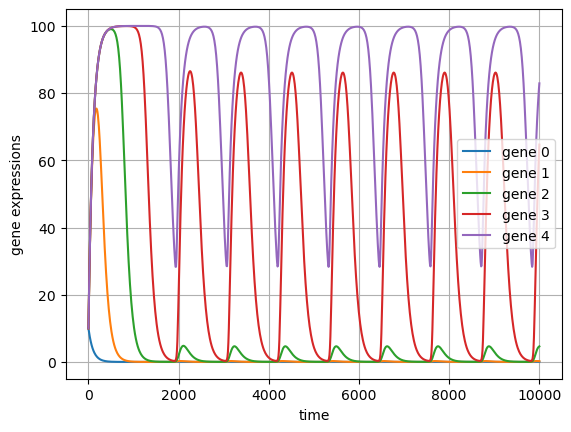

In [22]:
set_seed(0)
switch_cell_pop = CyclesHillFunctionProductionPop(cycle_graph, n_cells=20)

time_points = torch.linspace(0, 10000, 1000)
cell_traj = simulate_deterministic_trajectory(switch_cell_pop, time_points)
plot_trajectory(cell_traj[:, 0], time_points)

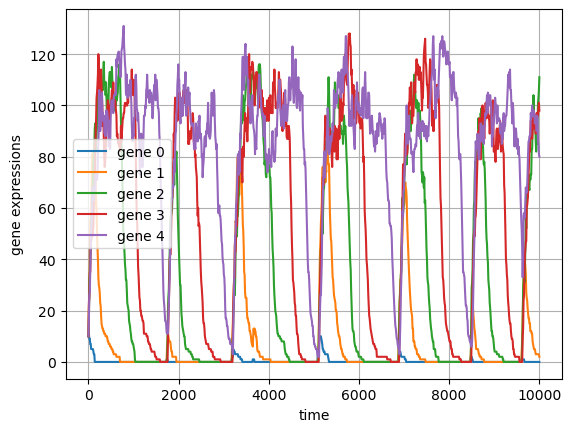

In [23]:
set_seed(0)
switch_cell_pop = CyclesHillFunctionProductionPop(cycle_graph, n_cells=20)

time_points = torch.linspace(0, 10000, 1000)
cell_traj = simulate_stochastic_trajectory(switch_cell_pop, time_points)
plot_trajectory(cell_traj[:, 0], time_points)